# Drive mount & Unzip

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

# 파일 경로 입력
zip_file_name = '/content/drive/MyDrive/DACON/open.zip'

# 압축 해제할 경로 입력
extraction_dir = '/content/dataset'

# 압축 해제
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

In [1]:
cd /content/dataset

/content/dataset


## Import

In [2]:
import librosa
import librosa.display

import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random

from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import torch
#import torchmetrics
import os

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Config

In [8]:
class Config:
    SR = 32000
    N_MFCC = 128
    # Dataset
    ROOT_FOLDER = './'
    # Training
    N_CLASSES = 2
    #BATCH_SIZE = 96
    BATCH_SIZE = 48
    N_EPOCHS = 10
    LR = 3e-4

    CLIP_VALUE = 1.0
    # Others
    SEED = 42

CONFIG = Config()

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CONFIG.SEED) # Seed 고정

데이터 2초 단위로 나누기

In [15]:
import soundfile as sf

# CSV 파일 로드
df_train = pd.read_csv('train.csv')

# 데이터 저장을 위한 리스트 초기화
mfcc_data = []
mel_data = []
label_data = []
real_chunks = []
fake_chunks = []

# 라벨 카운트 초기화
label_count = {'real': 0, 'fake': 0, 'combined': 0}

def segment_audio(audio, sample_rate, segment_length=2):
    segment_samples = segment_length * sample_rate
    segments = []
    for i in range(0, len(audio), segment_samples):
        segment = audio[i:i+segment_samples]
        segments.append(segment)
    return segments

def random_pad(mels, pad_size, mfcc=True):
    pad_width = pad_size - mels.shape[1]
    if pad_width <= 0:
        return mels  # 패딩이 필요 없는 경우 원본 배열 반환
    rand = np.random.rand()
    left = int(pad_width * rand)
    right = pad_width - left

    if mfcc:
        mels = np.pad(mels, pad_width=((0, 0), (left, right)), mode='constant')
        local_max, local_min = mels.max(), mels.min()
        mels = (mels - local_min) / (local_max - local_min)
    else:
        local_max, local_min = mels.max(), mels.min()
        mels = (mels - local_min) / (local_max - local_min)
        mels = np.pad(mels, pad_width=((0, 0), (left, right)), mode='constant')

    return mels

def add_noise(audio, noise_factor=0.05):
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    augmented_audio = augmented_audio.astype(type(audio[0]))
    return augmented_audio

def overlay_audio(audio_2s, audio_1s, sr):
    max_offset = len(audio_2s) - len(audio_1s)
    start_position = random.randint(0, max_offset)
    combined_audio = np.copy(audio_2s)
    combined_audio[start_position:start_position+len(audio_1s)] += audio_1s
    return combined_audio

# 데이터셋에서 각 오디오 파일에 대해 처리
for index, row in tqdm(df_train.iterrows()):
    audio_path = row['path']
    label = row['label']

    # 오디오 파일 로드
    y, sr = librosa.load(audio_path, sr=CONFIG.SR)

    # 오디오 데이터 자르기
    segments = segment_audio(y, sr, segment_length=2)

    for chunk in segments:
        # 노이즈 추가
        if random.random() < 0.5:  # 일정 비율의 오디오에 노이즈 추가
            chunk = add_noise(chunk)

        if label == 'real':
            if len(chunk) < int(1.5 * sr):
                continue  # 1.5초보다 짧은 chunk는 무시
            elif len(chunk) < int(2.0 * sr):
                # 패딩하여 저장
                chunk = np.pad(chunk, (0, int(2.0 * sr) - len(chunk)), mode='constant')
                mfcc = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=CONFIG.N_MFCC)
                mels = librosa.feature.melspectrogram(y=chunk, sr=sr, n_mels=CONFIG.N_MFCC)
                mels = librosa.power_to_db(mels, ref=np.max)
                mfcc_data.append(random_pad(mfcc, pad_size=CONFIG.N_MFCC, mfcc=True))
                mel_data.append(random_pad(mels, pad_size=CONFIG.N_MFCC, mfcc=False))
                label_vector = np.zeros(CONFIG.N_CLASSES, dtype=float)
                label_vector[1] = 1
                label_data.append(label_vector)
                label_count['real'] += 1
            else:
                real_chunks.append(chunk)
        elif label == 'fake':
            if len(chunk) < int(1.0 * sr):
                continue  # 1초보다 짧은 chunk는 무시
            elif len(chunk) < int(1.5 * sr):
                fake_chunks.append(chunk)
            else:
                # 패딩하여 저장
                chunk = np.pad(chunk, (0, int(2.0 * sr) - len(chunk)), mode='constant')
                mfcc = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=CONFIG.N_MFCC)
                mels = librosa.feature.melspectrogram(y=chunk, sr=sr, n_mels=CONFIG.N_MFCC)
                mels = librosa.power_to_db(mels, ref=np.max)
                mfcc_data.append(random_pad(mfcc, pad_size=CONFIG.N_MFCC, mfcc=True))
                mel_data.append(random_pad(mels, pad_size=CONFIG.N_MFCC, mfcc=False))
                label_vector = np.zeros(CONFIG.N_CLASSES, dtype=float)
                label_vector[0] = 1
                label_data.append(label_vector)
                label_count['fake'] += 1

55438it [16:34, 55.72it/s]


In [16]:
# Fake 데이터와 Real 데이터를 합성하여 새로운 데이터 생성
for fake_chunk in tqdm(fake_chunks):

    real_chunk = real_chunks.pop(0)  # 순서대로 처리
    combined_audio = overlay_audio(real_chunk, fake_chunk, sr)

    # 노이즈 추가
    if random.random() < 0.5:  # 일정 비율의 오디오에 노이즈 추가
        combined_audio = add_noise(combined_audio)

    # MFCC 추출
    mfcc = librosa.feature.mfcc(y=combined_audio, sr=sr, n_mfcc=CONFIG.N_MFCC)

    # Mel spectrogram 추출
    mels = librosa.feature.melspectrogram(y=combined_audio, sr=sr, n_mels=CONFIG.N_MFCC)
    mels = librosa.power_to_db(mels, ref=np.max)

    # 랜덤 패딩
    pad_size = 128

    # 데이터 저장
    mfcc_data.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))
    mel_data.append(random_pad(mels, pad_size=pad_size, mfcc=False))
    label_vector = np.ones(CONFIG.N_CLASSES, dtype=float)  # [1,1] 레이블
    label_data.append(label_vector)
    label_count['combined'] += 1

# Overlay remaining real data to create new combined data
combined_real_chunks = real_chunks[:30228]
for i in tqdm(range(0, len(combined_real_chunks), 2)):
    if i + 1 >= len(combined_real_chunks):
        break
    real_chunk1 = combined_real_chunks[i]
    real_chunk2 = combined_real_chunks[i + 1]
    combined_audio = overlay_audio(real_chunk1, real_chunk2, sr)

    # 노이즈 추가
    if random.random() < 0.5:  # 일정 비율의 오디오에 노이즈 추가
        combined_audio = add_noise(combined_audio)

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=combined_audio, sr=sr, n_mfcc=CONFIG.N_MFCC)

    # Extract Mel spectrogram features
    mels = librosa.feature.melspectrogram(y=combined_audio, sr=sr, n_mels=CONFIG.N_MFCC)
    mels = librosa.power_to_db(mels, ref=np.max)

    # Random padding
    pad_size = 128

    # Save data
    mfcc_data.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))
    mel_data.append(random_pad(mels, pad_size=pad_size, mfcc=False))
    label_vector = np.zeros(CONFIG.N_CLASSES, dtype=float)
    label_vector[1] = 1  # 'real' label
    label_data.append(label_vector)
    label_count['real'] += 1

# Remove used real chunks from the original list
real_chunks = real_chunks[30228:]

# Remaining real chunks 처리하여 저장
for real_chunk in tqdm(real_chunks):
    mfcc = librosa.feature.mfcc(y=real_chunk, sr=sr, n_mfcc=CONFIG.N_MFCC)
    mels = librosa.feature.melspectrogram(y=real_chunk, sr=sr, n_mels=CONFIG.N_MFCC)
    mels = librosa.power_to_db(mels, ref=np.max)
    mfcc_data.append(random_pad(mfcc, pad_size=CONFIG.N_MFCC, mfcc=True))
    mel_data.append(random_pad(mels, pad_size=CONFIG.N_MFCC, mfcc=False))
    label_vector = np.zeros(CONFIG.N_CLASSES, dtype=float)
    label_vector[1] = 1
    label_data.append(label_vector)
    label_count['real'] += 1

100%|██████████| 8380/8380 [04:51<00:00, 28.71it/s]


In [17]:
# 리스트를 넘파이 배열로 변환
mfcc_data = np.array(mfcc_data)
mel_data = np.array(mel_data)
label_data = np.array(label_data)

print("MFCC 데이터 형태:", mfcc_data.shape)
print("Mel 스펙트로그램 데이터 형태:", mel_data.shape)
print("라벨 데이터 형태:", label_data.shape)
print("레이블 분포:", label_count)

MFCC 데이터 형태: (55881, 128, 128)
Mel 스펙트로그램 데이터 형태: (55881, 128, 128)
라벨 데이터 형태: (55881, 2)
레이블 분포: {'real': 30473, 'fake': 15359, 'combined': 10049}


In [18]:
np.save('/content/drive/MyDrive/DACON/chunk/aug_mfcc_data.npy',mfcc_data)
np.save('/content/drive/MyDrive/DACON/chunk/aug_mel_data.npy',mel_data)
np.save('/content/drive/MyDrive/DACON/chunk/aug_label_data.npy',label_data)

In [19]:
print(mfcc_data.shape)
print(mel_data.shape)
print(label_data.shape)

(55881, 128, 128)
(55881, 128, 128)
(55881, 2)


In [10]:
test_mel_data=np.load('/content/drive/MyDrive/DACON/chunk/test_mel_data.npy')
test_mfcc_data=np.load('/content/drive/MyDrive/DACON/chunk/test_mfcc_data.npy')

print(test_mel_data.shape)
print(test_mfcc_data.shape)

(100000, 128, 128)
(100000, 128, 128)


In [11]:
mfcc_data=np.load('/content/drive/MyDrive/DACON/chunk/aug_mfcc_data.npy')
mel_data=np.load('/content/drive/MyDrive/DACON/chunk/aug_mel_data.npy')
label_data=np.load('/content/drive/MyDrive/DACON/chunk/aug_label_data.npy')

print(mfcc_data.shape)
print(mel_data.shape)
print(label_data.shape)

(55881, 128, 128)
(55881, 128, 128)
(55881, 2)


## 라벨 분포 확인

Label distribution:
[0. 1.]: 30473
[1. 0.]: 15359
[1. 1.]: 10049


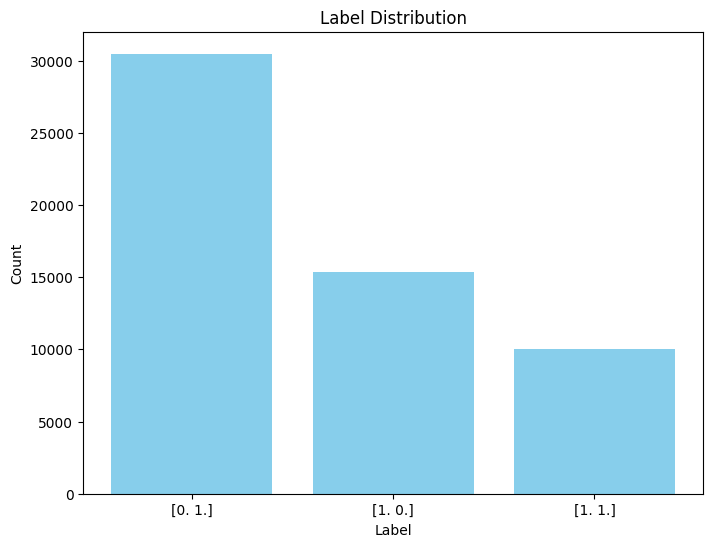

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 라벨 분포 확인
unique, counts = np.unique(label_data, axis=0, return_counts=True)
label_counts = {str(label): count for label, count in zip(unique, counts)}

# 출력
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

# 라벨 분포를 시각화
labels = [str(label) for label in unique]
counts = counts

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()


In [ ]:
# new label - label 균형
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample

# 라벨 분포 확인
unique, counts = np.unique(label_data, axis=0, return_counts=True)
label_counts = {str(label): count for label, count in zip(unique, counts)}

# 출력
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

# 클래스별 데이터 인덱스 추출
class_01_idx = np.where((label_data == [0, 1]).all(axis=1))[0]
class_10_idx = np.where((label_data == [1, 0]).all(axis=1))[0]
class_11_idx = np.where((label_data == [1, 1]).all(axis=1))[0]

# 소수 클래스의 샘플 수 확인
min_class_samples = len(class_10_idx)

# 초반 10049개 제외
class_01_idx_to_use = class_01_idx[10049:]

# 다수 클래스에서 소수 클래스 샘플 수만큼 랜덤 샘플링
class_01_sampled_idx = np.random.choice(class_01_idx_to_use, min_class_samples, replace=False)

# 새로운 데이터셋 생성
new_indices = np.concatenate([class_01_sampled_idx, class_10_idx, class_11_idx])
np.random.shuffle(new_indices)  # 섞기

# 데이터셋 추출
new_mel_data = mel_data[new_indices]
new_mfcc_data = mfcc_data[new_indices]
new_label_data = label_data[new_indices]

# 남은 [0, 1] 인덱스 추출
remaining_class_01_idx = np.setdiff1d(class_01_idx, class_01_sampled_idx)

# 새로운 라벨 분포 확인
new_unique, new_counts = np.unique(new_label_data, axis=0, return_counts=True)
new_label_counts = {str(label): count for label, count in zip(new_unique, new_counts)}

# 출력
print("\nNew label distribution:")
for label, count in new_label_counts.items():
    print(f"{label}: {count}")

# 새로운 라벨 분포를 시각화
new_labels = [str(label) for label in new_unique]
new_counts = new_counts

plt.figure(figsize=(8, 6))
plt.bar(new_labels, new_counts, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('New Label Distribution')
plt.show()
'''

In [34]:
print(new_mel_data.shape)
print(new_mfcc_data.shape)

print(new_label_data.shape)
print(new_label_data[0])

#check for NAN values
print(np.isnan(new_mel_data).any())
print(np.isnan(new_mfcc_data).any())
print(np.isnan(new_label_data).any())

(40767, 128, 128)
(40767, 128, 128)
(40767, 2)
[1. 0.]
False
False
False


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimplifiedCNNMultiLabel(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):
        super(SimplifiedCNNMultiLabel, self).__init__()

        self.features = nn.Sequential(
            self._conv_block(in_channels, 32),
            nn.MaxPool2d(2),
            self._conv_block(32, 64),
            nn.MaxPool2d(2),
            self._conv_block(64, 128),
            nn.MaxPool2d(2),
            self._conv_block(128, 256),
            nn.AdaptiveAvgPool2d(1)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return torch.sigmoid(x)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNNMultiLabel(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):
        super(ImprovedCNNMultiLabel, self).__init__()

        self.features = nn.Sequential(
            self._conv_block(in_channels, 32),
            nn.MaxPool2d(2),
            self._conv_block(32, 64),
            nn.MaxPool2d(2),
            self._conv_block(64, 128),
            nn.MaxPool2d(2),
            self._conv_block(128, 256),
            nn.MaxPool2d(2),
            self._conv_block(256, 512),
            nn.AdaptiveAvgPool2d(1)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, groups=out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return torch.sigmoid(x)

In [20]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

def clip_predictions(predictions, epsilon=1e-7):
    return torch.clamp(predictions, epsilon, 1 - epsilon)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=CONFIG.N_EPOCHS):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_model = None

    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)
    best_auc = 0.0

    train_losses = []
    val_losses = []
    train_aucs = []
    val_aucs = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        epoch_train_preds = []
        epoch_train_labels = []

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = clip_predictions(outputs)

            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG.CLIP_VALUE)

            optimizer.step()
            epoch_train_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).cpu().detach().numpy()
            epoch_train_preds.append(preds)
            epoch_train_labels.append(labels.cpu().numpy())

        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        epoch_train_preds = np.concatenate(epoch_train_preds)
        epoch_train_labels = np.concatenate(epoch_train_labels)

        train_auc = roc_auc_score(epoch_train_labels, epoch_train_preds, average='weighted')

        train_aucs.append(train_auc)

        # Validation
        model.eval()
        val_preds = []
        val_labels = []
        epoch_val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_preds.append(torch.sigmoid(outputs).cpu().detach().numpy())
                val_labels.append(labels.cpu().numpy())
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item() * inputs.size(0)

        val_preds = np.concatenate(val_preds)
        val_labels = np.concatenate(val_labels)
        epoch_val_loss /= len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        val_auc = roc_auc_score(val_labels, val_preds, average='weighted')

        val_aucs.append(val_auc)

        # Print training and validation metrics
        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {epoch_train_loss:.4f}, Train AUC: {train_auc:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val AUC: {val_auc:.4f}")

        # Learning rate scheduling
        scheduler.step(val_auc)

        # Update best model if current AUC is better
        if val_auc > best_auc:
            best_auc = val_auc
            best_model = model.state_dict()

    # Load best model
    model.load_state_dict(best_model)

    return model, best_auc

# Main loop
auc_list = []
pred_list_mel = []  # Store predictions for Mel model
pred_list_mfcc = []  # Store predictions for MFCC model
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=CONFIG.SEED)

In [21]:
# Function to predict on multiple segments and aggregate results
def prediction(model, test_mfcc_data, device):
    model.eval()
    preds_list = []
    with torch.no_grad():
        for i in range(0, len(test_mfcc_data), 2):
            data_1 = test_mfcc_data[i]
            data_2 = test_mfcc_data[i + 1]

            inputs_1 = torch.Tensor(data_1).unsqueeze(0).unsqueeze(0).to(device)  # Assuming segment shape is (1, 1, segment_length)
            inputs_2 = torch.Tensor(data_2).unsqueeze(0).unsqueeze(0).to(device)

            preds_1 = model(inputs_1)
            preds_2 = model(inputs_2)

            # Take the average of predictions
            preds_avg = (preds_1 + preds_2) / 2.0
            preds_list.append(preds_avg.cpu().detach().numpy())

    return preds_list


In [ ]:
# Iterate over folds
for fold, (train_index, val_index) in enumerate(skf.split(mel_data, np.argmax(label_data, axis=1))):
    print(f'\n********** {fold+1} fold **********')

    # Mel spectrogram model
    #model_mel = SimplifiedCNNMultiLabel()
    model_mel = ImprovedCNNMultiLabel()

    #x_train_mel, x_val_mel = new_mel_data[train_index], new_mel_data[val_index]
    #y_train_mel, y_val_mel = new_label_data[train_index], new_label_data[val_index]

    x_train_mel, x_val_mel = mel_data[train_index], mel_data[val_index]
    y_train_mel, y_val_mel = label_data[train_index], label_data[val_index]

    train_dataset_mel = TensorDataset(torch.Tensor(x_train_mel).unsqueeze(1), torch.Tensor(y_train_mel))
    val_dataset_mel = TensorDataset(torch.Tensor(x_val_mel).unsqueeze(1), torch.Tensor(y_val_mel))

    train_loader_mel = DataLoader(train_dataset_mel, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
    val_loader_mel = DataLoader(val_dataset_mel, batch_size=CONFIG.BATCH_SIZE)

    #criterion_mel = nn.BCELoss(weight=class_weights)
    criterion_mel = nn.BCELoss()
    optimizer_mel = optim.Adam(model_mel.parameters(), lr=CONFIG.LR)

    # Mel spectrogram model

    model_mel, best_auc_mel = train_model(model_mel, train_loader_mel, val_loader_mel, criterion_mel, optimizer_mel)

    # Validation on full 5-second validation data for Mel model
    model_mel.eval()

    val_preds_mel = []
    val_labels_mel = []

    batch_size = CONFIG.BATCH_SIZE
    with torch.no_grad():
        for i in range(0, len(x_val_mel), batch_size):  # Batch processing
            inputs = torch.Tensor(x_val_mel[i:i+ batch_size]).to(device).unsqueeze(1)
            outputs = model_mel(inputs)
            val_preds_mel.extend(outputs.cpu().numpy())
            val_labels_mel.extend(y_val_mel[i:i+ batch_size])

    val_preds_mel = np.array(val_preds_mel)
    val_labels_mel = np.array(val_labels_mel)
    auc_mel = roc_auc_score(val_labels_mel, val_preds_mel, average='weighted')

    print(f'mels_model_auc : {auc_mel:.4f}')

    # Store predictions on test data for Mel model
    preds_test_mel = prediction(model_mel, test_mel_data, device)
    pred_list_mel.append(preds_test_mel)

    # MFCC model
    #model_mfcc = MultiLabelResNet()
    #model_mfcc = SimplifiedCNNMultiLabel()
    model_mfcc = ImprovedCNNMultiLabel()

    #x_train_mfcc, x_val_mfcc = new_mfcc_data[train_index], new_mfcc_data[val_index]
    #y_train_mfcc, y_val_mfcc = new_label_data[train_index], new_label_data[val_index]

    x_train_mfcc, x_val_mfcc = mfcc_data[train_index], mfcc_data[val_index]
    y_train_mfcc, y_val_mfcc = label_data[train_index], label_data[val_index]

    train_dataset_mfcc = TensorDataset(torch.Tensor(x_train_mfcc).unsqueeze(1), torch.Tensor(y_train_mfcc))
    val_dataset_mfcc = TensorDataset(torch.Tensor(x_val_mfcc).unsqueeze(1), torch.Tensor(y_val_mfcc))
    train_loader_mfcc = DataLoader(train_dataset_mfcc, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
    val_loader_mfcc = DataLoader(val_dataset_mfcc, batch_size=CONFIG.BATCH_SIZE)

    optimizer_mfcc = optim.Adam(model_mfcc.parameters(), lr=CONFIG.LR)

    #criterion_mfcc = nn.BCELoss(weight=class_weights)
    criterion_mfcc = nn.BCELoss()

    model_mfcc, best_auc_mfcc = train_model(model_mfcc, train_loader_mfcc, val_loader_mfcc, criterion_mel, optimizer_mfcc)

    # Validation on full 5-second validation data for MFCC model
    model_mfcc.eval()
    val_preds_mfcc = []
    val_labels_mfcc = []

    batch_size = CONFIG.BATCH_SIZE
    with torch.no_grad():
        for i in range(0, len(x_val_mfcc), batch_size):  # Batch processing
            inputs = torch.Tensor(x_val_mfcc[i:i+batch_size]).to(device).unsqueeze(1)
            outputs = model_mfcc(inputs)
            val_preds_mfcc.extend(outputs.cpu().numpy())
            val_labels_mfcc.extend(y_val_mel[i:i+batch_size])

    val_preds_mfcc = np.array(val_preds_mfcc)
    val_labels_mfcc = np.array(val_labels_mfcc)
    auc_mfcc = roc_auc_score(val_labels_mfcc, val_preds_mfcc, average='weighted')

    print(f'mfcc_model_auc : {auc_mfcc:.4f}')

    # Store predictions on test data for MFCC model
    preds_test_mfcc = prediction(model_mfcc, test_mfcc_data, device)
    pred_list_mfcc.append(preds_test_mfcc)

    # Print fold ensemble metrics if needed
    print(f'Ensemble metrics for fold {fold+1}')

# Calculate mean predictions from all folds
pred_mean_mel = np.mean(pred_list_mel, axis=0)
pred_mean_mfcc = np.mean(pred_list_mfcc, axis=0)

# Perform final ensemble by averaging predictions
final_pred_mean = (pred_mean_mel + pred_mean_mfcc) / 2.0


********** 1 fold **********


Epoch 1/10: 100%|██████████| 874/874 [01:07<00:00, 12.92it/s]


Epoch 1/10, Train Loss: 0.2554, Train AUC: 0.9606, Val Loss: 0.6918, Val AUC: 0.9536


Epoch 2/10: 100%|██████████| 874/874 [01:08<00:00, 12.79it/s]


Epoch 2/10, Train Loss: 0.1173, Train AUC: 0.9909, Val Loss: 0.1398, Val AUC: 0.9928


Epoch 3/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 3/10, Train Loss: 0.0844, Train AUC: 0.9948, Val Loss: 0.0678, Val AUC: 0.9974


Epoch 4/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 4/10, Train Loss: 0.0659, Train AUC: 0.9966, Val Loss: 0.0564, Val AUC: 0.9981


Epoch 5/10: 100%|██████████| 874/874 [01:08<00:00, 12.79it/s]


Epoch 5/10, Train Loss: 0.0535, Train AUC: 0.9976, Val Loss: 0.0449, Val AUC: 0.9986


Epoch 6/10: 100%|██████████| 874/874 [01:08<00:00, 12.80it/s]


Epoch 6/10, Train Loss: 0.0473, Train AUC: 0.9982, Val Loss: 0.0625, Val AUC: 0.9981


Epoch 7/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 7/10, Train Loss: 0.0394, Train AUC: 0.9986, Val Loss: 0.0770, Val AUC: 0.9987


Epoch 8/10: 100%|██████████| 874/874 [01:08<00:00, 12.82it/s]


Epoch 8/10, Train Loss: 0.0345, Train AUC: 0.9990, Val Loss: 0.0469, Val AUC: 0.9985


Epoch 9/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 9/10, Train Loss: 0.0144, Train AUC: 0.9997, Val Loss: 0.0255, Val AUC: 0.9995


Epoch 10/10: 100%|██████████| 874/874 [01:08<00:00, 12.80it/s]


Epoch 10/10, Train Loss: 0.0090, Train AUC: 0.9999, Val Loss: 0.0306, Val AUC: 0.9995
mels_model_auc : 0.9995


Epoch 1/10: 100%|██████████| 874/874 [01:08<00:00, 12.80it/s]


Epoch 1/10, Train Loss: 0.4319, Train AUC: 0.8824, Val Loss: 0.4441, Val AUC: 0.9008


Epoch 2/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 2/10, Train Loss: 0.2096, Train AUC: 0.9723, Val Loss: 0.1514, Val AUC: 0.9889


Epoch 3/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 3/10, Train Loss: 0.1447, Train AUC: 0.9861, Val Loss: 0.1471, Val AUC: 0.9869


Epoch 4/10: 100%|██████████| 874/874 [01:08<00:00, 12.82it/s]


Epoch 4/10, Train Loss: 0.1206, Train AUC: 0.9901, Val Loss: 0.3769, Val AUC: 0.9533


Epoch 5/10: 100%|██████████| 874/874 [01:08<00:00, 12.82it/s]


Epoch 5/10, Train Loss: 0.1007, Train AUC: 0.9930, Val Loss: 0.0882, Val AUC: 0.9963


Epoch 6/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 6/10, Train Loss: 0.0864, Train AUC: 0.9947, Val Loss: 0.0739, Val AUC: 0.9970


Epoch 7/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 7/10, Train Loss: 0.0742, Train AUC: 0.9960, Val Loss: 0.0747, Val AUC: 0.9966


Epoch 8/10: 100%|██████████| 874/874 [01:08<00:00, 12.78it/s]


Epoch 8/10, Train Loss: 0.0648, Train AUC: 0.9967, Val Loss: 0.4523, Val AUC: 0.9621


Epoch 9/10: 100%|██████████| 874/874 [01:08<00:00, 12.80it/s]


Epoch 9/10, Train Loss: 0.0512, Train AUC: 0.9978, Val Loss: 0.1865, Val AUC: 0.9890


Epoch 10/10: 100%|██████████| 874/874 [01:08<00:00, 12.79it/s]


Epoch 10/10, Train Loss: 0.0230, Train AUC: 0.9995, Val Loss: 0.0541, Val AUC: 0.9985
mfcc_model_auc : 0.9985
Ensemble metrics for fold 1

********** 2 fold **********


Epoch 1/10: 100%|██████████| 874/874 [01:08<00:00, 12.70it/s]


Epoch 1/10, Train Loss: 0.2527, Train AUC: 0.9612, Val Loss: 0.3363, Val AUC: 0.9805


Epoch 2/10: 100%|██████████| 874/874 [01:08<00:00, 12.80it/s]


Epoch 2/10, Train Loss: 0.1168, Train AUC: 0.9908, Val Loss: 0.1303, Val AUC: 0.9940


Epoch 3/10: 100%|██████████| 874/874 [01:08<00:00, 12.80it/s]


Epoch 3/10, Train Loss: 0.0858, Train AUC: 0.9945, Val Loss: 0.0559, Val AUC: 0.9977


Epoch 4/10: 100%|██████████| 874/874 [01:08<00:00, 12.80it/s]


Epoch 4/10, Train Loss: 0.0691, Train AUC: 0.9964, Val Loss: 0.1047, Val AUC: 0.9970


Epoch 5/10: 100%|██████████| 874/874 [01:08<00:00, 12.82it/s]


Epoch 5/10, Train Loss: 0.0563, Train AUC: 0.9974, Val Loss: 0.0464, Val AUC: 0.9987


Epoch 6/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 6/10, Train Loss: 0.0490, Train AUC: 0.9980, Val Loss: 0.0564, Val AUC: 0.9981


Epoch 7/10: 100%|██████████| 874/874 [01:08<00:00, 12.80it/s]


Epoch 7/10, Train Loss: 0.0410, Train AUC: 0.9985, Val Loss: 0.0487, Val AUC: 0.9984


Epoch 8/10: 100%|██████████| 874/874 [01:08<00:00, 12.80it/s]


Epoch 8/10, Train Loss: 0.0365, Train AUC: 0.9988, Val Loss: 0.0493, Val AUC: 0.9985


Epoch 9/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 9/10, Train Loss: 0.0166, Train AUC: 0.9997, Val Loss: 0.0285, Val AUC: 0.9992


Epoch 10/10: 100%|██████████| 874/874 [01:08<00:00, 12.80it/s]


Epoch 10/10, Train Loss: 0.0099, Train AUC: 0.9998, Val Loss: 0.0290, Val AUC: 0.9993
mels_model_auc : 0.9993


Epoch 1/10: 100%|██████████| 874/874 [01:08<00:00, 12.80it/s]


Epoch 1/10, Train Loss: 0.4341, Train AUC: 0.8784, Val Loss: 0.3284, Val AUC: 0.9398


Epoch 2/10: 100%|██████████| 874/874 [01:08<00:00, 12.84it/s]


Epoch 2/10, Train Loss: 0.2088, Train AUC: 0.9727, Val Loss: 0.1366, Val AUC: 0.9887


Epoch 3/10: 100%|██████████| 874/874 [01:08<00:00, 12.82it/s]


Epoch 3/10, Train Loss: 0.1477, Train AUC: 0.9859, Val Loss: 0.1769, Val AUC: 0.9885


Epoch 4/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 4/10, Train Loss: 0.1206, Train AUC: 0.9905, Val Loss: 0.0986, Val AUC: 0.9937


Epoch 5/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 5/10, Train Loss: 0.1011, Train AUC: 0.9929, Val Loss: 0.0736, Val AUC: 0.9963


Epoch 6/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 6/10, Train Loss: 0.0860, Train AUC: 0.9949, Val Loss: 0.1016, Val AUC: 0.9952


Epoch 7/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 7/10, Train Loss: 0.0764, Train AUC: 0.9959, Val Loss: 0.0714, Val AUC: 0.9966


Epoch 8/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 8/10, Train Loss: 0.0631, Train AUC: 0.9971, Val Loss: 0.0768, Val AUC: 0.9959


Epoch 9/10: 100%|██████████| 874/874 [01:08<00:00, 12.79it/s]


Epoch 9/10, Train Loss: 0.0567, Train AUC: 0.9975, Val Loss: 0.0846, Val AUC: 0.9960


Epoch 10/10: 100%|██████████| 874/874 [01:08<00:00, 12.79it/s]


Epoch 10/10, Train Loss: 0.0520, Train AUC: 0.9979, Val Loss: 0.1230, Val AUC: 0.9959
mfcc_model_auc : 0.9959
Ensemble metrics for fold 2

********** 3 fold **********


Epoch 1/10: 100%|██████████| 874/874 [01:08<00:00, 12.78it/s]


Epoch 1/10, Train Loss: 0.2519, Train AUC: 0.9616, Val Loss: 0.1579, Val AUC: 0.9915


Epoch 2/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 2/10, Train Loss: 0.1175, Train AUC: 0.9907, Val Loss: 0.0771, Val AUC: 0.9964


Epoch 3/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 3/10, Train Loss: 0.0894, Train AUC: 0.9943, Val Loss: 0.0829, Val AUC: 0.9970


Epoch 4/10: 100%|██████████| 874/874 [01:08<00:00, 12.79it/s]


Epoch 4/10, Train Loss: 0.0677, Train AUC: 0.9964, Val Loss: 0.0542, Val AUC: 0.9978


Epoch 5/10: 100%|██████████| 874/874 [01:08<00:00, 12.79it/s]


Epoch 5/10, Train Loss: 0.0591, Train AUC: 0.9974, Val Loss: 0.0516, Val AUC: 0.9984


Epoch 6/10: 100%|██████████| 874/874 [01:08<00:00, 12.80it/s]


Epoch 6/10, Train Loss: 0.0495, Train AUC: 0.9980, Val Loss: 0.0568, Val AUC: 0.9986


Epoch 7/10: 100%|██████████| 874/874 [01:08<00:00, 12.80it/s]


Epoch 7/10, Train Loss: 0.0429, Train AUC: 0.9984, Val Loss: 0.0430, Val AUC: 0.9988


Epoch 8/10: 100%|██████████| 874/874 [01:08<00:00, 12.79it/s]


Epoch 8/10, Train Loss: 0.0384, Train AUC: 0.9986, Val Loss: 0.0579, Val AUC: 0.9988


Epoch 9/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 9/10, Train Loss: 0.0329, Train AUC: 0.9990, Val Loss: 0.0597, Val AUC: 0.9990


Epoch 10/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 10/10, Train Loss: 0.0256, Train AUC: 0.9994, Val Loss: 0.0519, Val AUC: 0.9989
mels_model_auc : 0.9989


Epoch 1/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 1/10, Train Loss: 0.4333, Train AUC: 0.8809, Val Loss: 0.3292, Val AUC: 0.9524


Epoch 2/10: 100%|██████████| 874/874 [01:08<00:00, 12.83it/s]


Epoch 2/10, Train Loss: 0.2005, Train AUC: 0.9744, Val Loss: 0.1291, Val AUC: 0.9897


Epoch 3/10: 100%|██████████| 874/874 [01:08<00:00, 12.83it/s]


Epoch 3/10, Train Loss: 0.1468, Train AUC: 0.9860, Val Loss: 0.2225, Val AUC: 0.9902


Epoch 4/10: 100%|██████████| 874/874 [01:08<00:00, 12.83it/s]


Epoch 4/10, Train Loss: 0.1197, Train AUC: 0.9904, Val Loss: 0.0931, Val AUC: 0.9944


Epoch 5/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 5/10, Train Loss: 0.0978, Train AUC: 0.9932, Val Loss: 0.1176, Val AUC: 0.9926


Epoch 6/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 6/10, Train Loss: 0.0831, Train AUC: 0.9951, Val Loss: 0.1676, Val AUC: 0.9951


Epoch 7/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 7/10, Train Loss: 0.0729, Train AUC: 0.9962, Val Loss: 0.2072, Val AUC: 0.9934


Epoch 8/10: 100%|██████████| 874/874 [01:08<00:00, 12.80it/s]


Epoch 8/10, Train Loss: 0.0621, Train AUC: 0.9970, Val Loss: 0.0978, Val AUC: 0.9957


Epoch 9/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 9/10, Train Loss: 0.0536, Train AUC: 0.9978, Val Loss: 0.0931, Val AUC: 0.9965


Epoch 10/10: 100%|██████████| 874/874 [01:08<00:00, 12.80it/s]


Epoch 10/10, Train Loss: 0.0461, Train AUC: 0.9982, Val Loss: 0.0937, Val AUC: 0.9972
mfcc_model_auc : 0.9972
Ensemble metrics for fold 3

********** 4 fold **********


Epoch 1/10: 100%|██████████| 874/874 [01:08<00:00, 12.76it/s]


Epoch 1/10, Train Loss: 0.2508, Train AUC: 0.9610, Val Loss: 0.2169, Val AUC: 0.9911


Epoch 2/10: 100%|██████████| 874/874 [01:08<00:00, 12.78it/s]


Epoch 2/10, Train Loss: 0.1151, Train AUC: 0.9910, Val Loss: 0.0661, Val AUC: 0.9973


Epoch 3/10: 100%|██████████| 874/874 [01:08<00:00, 12.81it/s]


Epoch 3/10, Train Loss: 0.0895, Train AUC: 0.9943, Val Loss: 0.1127, Val AUC: 0.9963


Epoch 4/10: 100%|██████████| 874/874 [01:08<00:00, 12.80it/s]


Epoch 4/10, Train Loss: 0.0710, Train AUC: 0.9963, Val Loss: 0.0679, Val AUC: 0.9972


Epoch 5/10:  94%|█████████▍| 822/874 [01:04<00:04, 12.79it/s]

In [ ]:
#save model
torch.save(model_mel.state_dict(), '/content/drive/MyDrive/DACON/chunk/aug2_model_mel.pth')
torch.save(model_mfcc.state_dict(), '/content/drive/MyDrive/DACON/chunk/aug2_model_mfcc.pth')

In [ ]:
import pandas as pd
%cd /content/drive/MyDrive/DACON
submit = pd.read_csv('./sample_submission.csv')
#submit=submit[:len(y_valid)]
submit.head(3)
submit.shape

In [ ]:
final_pred_mean.shape

# final_pred_mean의 형태를 (50000, 2)로 변환
final_pred_mean_reshaped = final_pred_mean.reshape((50000, 2))

final_pred_mean_reshaped.shape

In [ ]:
submit.iloc[:, 1:] = final_pred_mean_reshaped

submit.head(10)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# preds가 리스트인 경우 numpy 배열로 변환
preds = np.array(final_pred_mean_reshaped)

# 예측값의 통계 정보 확인
print("Preds statistics:")
print(pd.DataFrame(preds).describe())

# NaN 값 확인
nan_mask = np.isnan(preds)
print("Number of NaN values:", np.sum(nan_mask))

# NaN 값을 0으로 대체 (또는 다른 적절한 값으로 대체 가능)
preds = np.nan_to_num(preds)

# 히스토그램으로 분포 시각화
plt.figure(figsize=(12, 6))

# Real 레이블의 분포
plt.subplot(1, 2, 1)
plt.hist(preds[:, 1], bins=50, alpha=0.75, color='blue', label='Real')
plt.title('Distribution of Real Predictions')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()

# Fake 레이블의 분포
plt.subplot(1, 2, 2)
plt.hist(preds[:, 0], bins=50, alpha=0.75, color='red', label='Fake')
plt.title('Distribution of Fake Predictions')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


# 가짜 음성을 분류하지 못하는지 확인
fake_preds = preds[:, 0]
real_preds = preds[:, 1]

# Fake 레이블에 대한 기본 통계 확인
print("\nFake label predictions:")
print(f"Min: {fake_preds.min()}")
print(f"Max: {fake_preds.max()}")
print(f"Mean: {fake_preds.mean()}")
print(f"Median: {np.median(fake_preds)}")

# Real 레이블에 대한 기본 통계 확인
print("\nReal label predictions:")
print(f"Min: {real_preds.min()}")
print(f"Max: {real_preds.max()}")
print(f"Mean: {real_preds.mean()}")
print(f"Median: {np.median(real_preds)}")


In [ ]:
submit.iloc[:, 1:] = preds
submit.to_csv('0715_mels_mfcc_aug_ImprovedCNN.csv', index=False)

In [22]:
!pip install torchinfo